# Basic demo of rolling out trained GNN.
All the scripts are in **scripts.gnn.gnn** and **scripts.gnn.gnn_definition**.

Each GNN model has 1) model spec 2) training spec.
Each dataset has data spec.

We first load trained GNN and the test dataset, then rollout GNN prediction.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import combinations
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as functional
from torch_geometric.data import Batch, Data, DataLoader

from collab_env.data.file_utils import expand_path, get_project_root
from collab_env.data.boids.animal_simulation import visualize_graph, visualize_pair
from collab_env.gnn.gnn import (get_adjcency_from_debug, plot_log_loss, train_rules_gnn,
    identify_frames, find_frame_sets, load_model, debug_result2prediction)
from collab_env.gnn.utility import handle_discrete_data
from collab_env.gnn.gnn_definition import GNN, Lazy
from collab_env.data.boids.animal_simulation import visualize_graph_2sets
from collab_env.gnn.plot_helpers import (rollout_to_pos_vel_acc,
    data_to_pos_vel_acc,
    return_deltapos_vnext,
    figure_data_C)
from collab_env.gnn.plotting_utility import load_various_data
from collab_env.gnn.utility import dataset2testloader
from itertools import product
from rich import print

In [3]:
smoke_test = "CI" in os.environ

steps = 1000 if not smoke_test else 10
# %%

In [120]:
# debug

In [ ]:
data_name = "boid_food_basic"
file_name = f'{data_name}.pt'
config_name = f'{data_name}_config.pt'

dataset = torch.load(expand_path(
                "simulated_data/" + file_name, get_project_root()), weights_only = False)

In [5]:
test_loader = dataset2testloader(dataset, batch_size = 1)
len(test_loader)

300

In [121]:
# end debug

### Data

In [17]:

data_names = ['boid_food_basic']#, 'boid_single_species_independent', # without food
              #'boid_food_basic_alignment', 'boid_food_basic_independent', # with food
              #'boid_food_strong'] # with food, strong influence

data = load_various_data(data_names, batch_size=50)
model_root_path = "trained_models/food/trained_models"

### Load GNN

In [18]:
model_names = ["vpluspplus_a"]
noise_levels = [0]
heads = [1]
visual_ranges = [0.5]
seed = 0

all_combinations = list(product(data_names, model_names, noise_levels, heads, visual_ranges))

models = {}

ind = 0
for (data_name, model_name, noise, head, visual_range) in all_combinations:
    
    
    save_name_postfix = f"n{noise}_h{head}_vr{visual_range}"
    file_name = f"{data_name}_{model_name}_{save_name_postfix}_s{seed}"

    models[ind] = {}
    models[ind]["file_name"] = file_name
    models[ind]["data_name"] = data_name
    models[ind]["model"], models[ind]["model_spec"], models[ind]["train_spec"] = load_model(model_name, file_name, root_path = model_root_path)

    ind += 1
    

2025-08-25 13:52:17.034 | DEBUG    | collab_env.gnn.gnn:load_model:931 - Loaded model spec.
2025-08-25 13:52:17.034 | DEBUG    | collab_env.gnn.gnn:load_model:936 - Loaded training spec.
2025-08-25 13:52:17.039 | DEBUG    | collab_env.gnn.gnn:load_model:957 - Loaded model.


### Rollout GNN

In [16]:
print("data keys:", data.keys())
print("models keys:", models.keys())

data keys: dict_keys(['boid_food_basic'])

models keys: dict_keys([0])

In [20]:
# do rollout
rollout_starting_frame = 5 #starting
torch.cuda.empty_cache()

for m in models.keys():
    data_name = models[m]["data_name"]
    file_name = models[m]["file_name"]
    
    dataloader = data[data_name]["test_loader"]
    
    gnn_model = models[m]["model"]
    gnn_training_spec = models[m]["train_spec"]

    gnn_training_spec["training"] = False
    gnn_training_spec["lr"] = None
    gnn_training_spec["rollout"] = rollout_starting_frame

    gnn_training_spec["ablate_boid_interaction"] = False

    _, species = list(dataloader)[0]

    # rollout
    (models[m]["rollout_losses"], _, models[m]["rollout_debug_result"]) = train_rules_gnn(
        gnn_model,
        dataloader,
        species_dim=len(torch.unique(species)),
        **gnn_training_spec
    )

    rollout_path = expand_path(
            f"{model_root_path}/rollouts/{file_name}_rollout_{rollout_starting_frame}.pkl",
            get_project_root()
    )

    # 
    with open(rollout_path, "wb") as f: # 'wb' for write binary
        pickle.dump(models[m]["rollout_debug_result"], f)

2025-08-25 14:12:25.373 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:594 - rolling out...
2025-08-25 14:12:25.373 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:600 - Starting epoch 1/1
2025-08-25 14:12:25.378 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:608 - Epoch 1/1 | Processing batch 1/6
2025-08-25 14:12:33.901 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:608 - Epoch 1/1 | Processing batch 2/6
2025-08-25 14:12:42.228 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:608 - Epoch 1/1 | Processing batch 3/6
2025-08-25 14:12:51.432 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:608 - Epoch 1/1 | Processing batch 4/6
2025-08-25 14:13:00.239 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:608 - Epoch 1/1 | Processing batch 5/6
2025-08-25 14:13:08.838 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:608 - Epoch 1/1 | Processing batch 6/6
2025-08-25 14:13:18.158 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:632 - Epoch 000 | Train loss: 22.42


### Plot Rollout

In [21]:
file_id = 20
m = 0
rollout_debug_result = models[m]["rollout_debug_result"]

In [22]:
pos, vel, acc, pos_gnn, vel_gnn, acc_gnn, frame_sets = debug_result2prediction(rollout_debug_result,
                                                                               file_id = file_id)

IndexError: list index out of range

p0 shape torch.Size([20, 2])
p shape torch.Size([996, 20, 2])


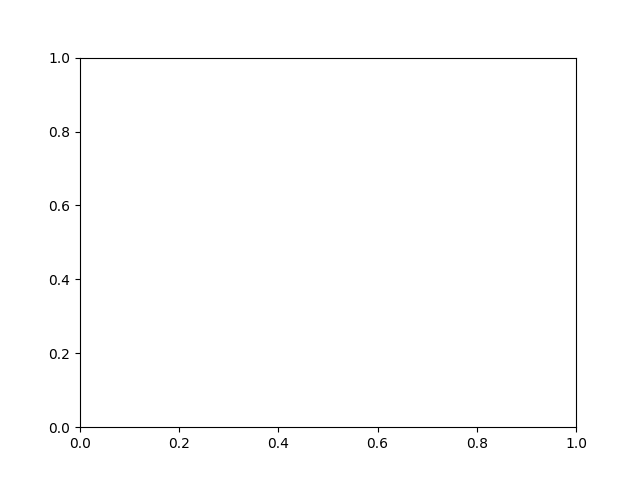

In [103]:
%matplotlib widget
starting_frame = 5
ending_frame = 300
ani, ax = visualize_graph_2sets(pos[0], vel[0], pos_gnn[0], vel_gnn[0],
                starting_frame = starting_frame, ending_frame = ending_frame,
                file_id = 0)

#ani.save(f'boid_rollout_file{file_id}_frame{starting_frame}_frame{ending_frame}_{prediction_integration}.gif',
#         writer='pillow', fps=20)

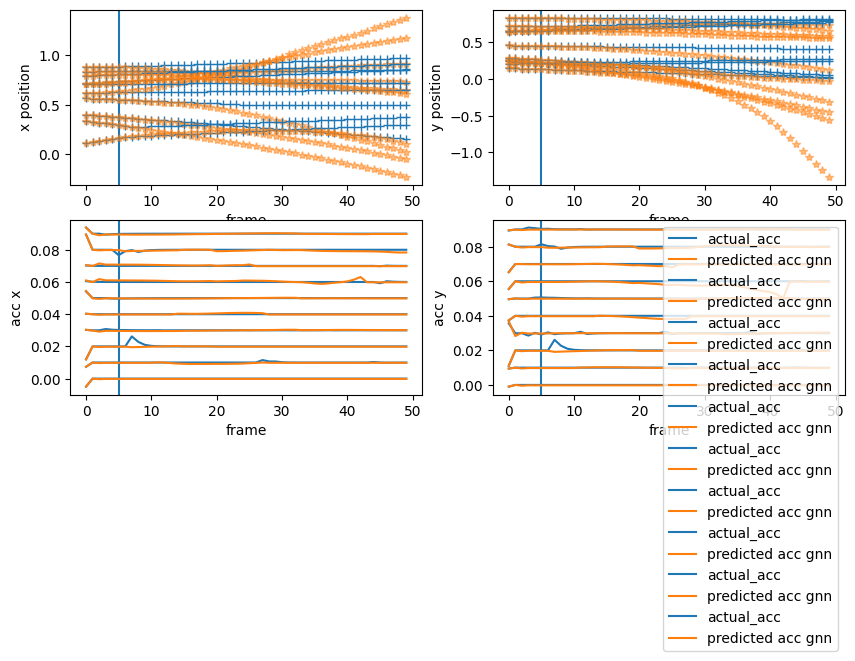

In [116]:
%matplotlib inline

t0, t1 = 0,50
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax = ax.ravel()
for a in ax:
    a.axvline(rollout_starting_frame)

for b in np.arange(10):

    ax[0].plot(pos[0,t0:t1, b, 0], "+", color = 'C0', label="actual")
    #ax[0].plot(predicted_lazy[:, b, 0], "*", label="predicted lazy", alpha=0.5)
    ax[0].plot(pos_gnn[0,t0:t1, b, 0], "*", color = 'C1',label="predicted gnn", alpha=0.5)
    
    #ax[0].set_title("bird " + str(b))
    
    ax[1].plot(pos[0,t0:t1, b, 1], "+", color = 'C0', label="actual")
    #ax[1].plot(predicted_lazy[:, b, 1], "*", label="predicted lazy", alpha=0.5)
    ax[1].plot(pos_gnn[0,t0:t1, b, 1], "*", color = 'C1',label="predicted gnn", alpha=0.5)
    
    #ax[1].set_title("bird " + str(b))
    
    ax[2].plot(acc[0,t0:t1, b, 0] + 0.01 * b, color = 'C0', label="actual_acc")
    #ax[2].plot(predicted_acc_lazy[:, b, 0], "+", label="predicted acc lazy")
    ax[2].plot(acc_gnn[0,t0:t1, b, 0] + 0.01 * b, color = 'C1',label="predicted acc gnn")
    #ax[2].plot(loss_acc, label="acc loss")
    
    
    ax[3].plot(acc[0,t0:t1, b, 1] + 0.01 * b, color = 'C0', label="actual_acc")
    #ax[3].plot(predicted_acc_lazy[:, b, 1], "+", label="predicted acc lazy")
    ax[3].plot(acc_gnn[0,t0:t1, b, 1] + 0.01 * b, color = 'C1',label="predicted acc gnn")

ax[0].set_xlabel("frame")
ax[0].set_ylabel("x position")

ax[1].set_xlabel("frame")
ax[1].set_ylabel("y position")

ax[2].set_xlabel("frame")
ax[2].set_ylabel("acc x")

#ax[3].plot(loss_acc, label="acc loss")
ax[3].set_xlabel("frame")
ax[3].set_ylabel("acc y")

plt.legend()
plt.show()


#### b) visualize the dynamic weight matrices
Because the attention layer is a function 
$$A: F \times F \rightarrow \mathbb{R} $$, where $F$ is the space of node feature, a subset of $\mathbb{R}^n$, n is the dimensionality of the input layer size, we obtain dynamic adjacency matrix as boids move around producing dynamic node features.

In [50]:
m = "vpluspplus_a"
W_output = models[m]["W_output"]

In [51]:
# choose a file
file_id = 3

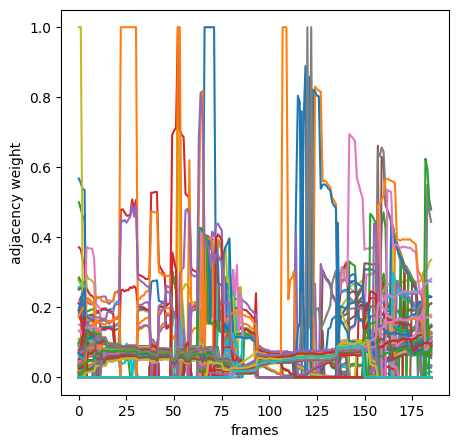

In [52]:
%matplotlib inline


final_epoch = list(W_output.keys())[-1]
W_output_overtime = W_output[final_epoch][file_id]
frames = np.arange(0, len(W_output_overtime))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
pairs = combinations(np.arange(np.shape(W_output_overtime[0])[0]), 2)
for p in pairs:
    W_output_overtime_ij = [W_output_overtime[t][p[0], p[1]] for t in frames]
    plt.plot(frames, W_output_overtime_ij)
plt.xlabel("frames")
plt.ylabel("adjacency weight")
plt.show()

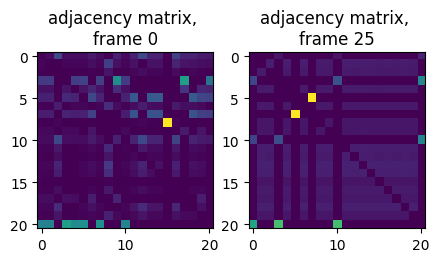

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(5, 5))
f0 = 0
f1 = 25
ax[0].imshow(W_output_overtime[f0])
ax[0].set_title(f"adjacency matrix, \nframe {f0}")
ax[1].imshow(W_output_overtime[f1])
ax[1].set_title(f"adjacency matrix, \nframe {f1}")
plt.show()

## 4. Validate on held-out dataset

In [63]:
file_name = 'boid_food_basic_alignment.pt'

models = {}
for old_name in ["vpluspplus_a"]:

    new_name = old_name
    sigma = 0.005
    
    
    model_path = expand_path(
            f"trained_models/{file_name[:-3]}_{old_name}_basic_noise_{sigma}_specialframes.pt",
            get_project_root())
    
    
    models[new_name] = load_model(new_name, model_path)
    

In [64]:
torch.cuda.empty_cache()

In [65]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
dataloader_list = list(test_loader)
visual_range = 0.5

In [66]:
training = False
epoch_num = 1
lr = None

for m in ["vpluspplus_a"]:#models:

    (
        node_feature_function,
        node_prediction,
        input_differentiation,
        prediction_integration,
        in_node_dim,
        start_frame,
    ) = (
        models[m]["node_feature_function"],
        models[m]["node_prediction"],
        models[m]["input_differentiation"],
        models[m]["prediction_integration"],
        models[m]["in_node_dim"],
        models[m]["start_frame"],
    )

    gnn_model = models[m]["model"]

    # train models
    (models[m]["test_losses"], _, models[m]["test_debug_result"]) = train_rules_gnn(
        gnn_model,
        test_loader,
        visual_range=visual_range,
        epochs=epoch_num,
        lr=lr,
        training=training,
        species_dim=len(torch.unique(species)),
        device=None,
    )

    models[m]["test_W_input"], models[m]["test_W_output"] = get_adjcency_from_debug(
        models[m]["test_debug_result"], test_loader, visual_range
    )

epoch 0


batch 0




/workspace/collab-environment/collab_env/gnn/gnn.py:376: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/workspace/collab-environment/collab_env/gnn/gnn.py:377: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(pos)
/workspace/collab-environment/collab_env/gnn/gnn.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vel = torch.tensor(vel)
/workspace/collab-environment/collab_env/gnn/gnn.py:439: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clo

batch 1


batch 2


batch 3


batch 4


batch 5


batch 6


batch 7


batch 8


batch 9


batch 10


batch 11


batch 12


batch 13


batch 14


batch 15


batch 16


batch 17


batch 18


batch 19


batch 20


batch 21


batch 22


batch 23


batch 24


Epoch 000 | Train: 0.0012
finished one epoch


### Acceleration loss

In [ ]:
# plot all models
fig, ax = plt.subplots(figsize=(10, 3))

ind = 0
for m in models:
    name = m
    mean = np.mean(models[m]["test_losses"])
    std_devs = 2 * np.std(models[m]["test_losses"])
    ax.bar(ind, mean, width=0.6)
    # ax.errorbar(ind, mean, yerr=std_devs, fmt="none", color='black', capsize=5)

    ind += 1
ax.set_xticks(np.arange(len(models)), labels=[m for m in models])
ax.set_ylabel("Test loss (acceleration)")
plt.yscale("log", base=10)
plt.show()

### MSE position loss

In [ ]:
test_loss_mse_all = {}
for m in models:
    loss_m = []
    epoch_num = list(models[m]["test_debug_result"].keys())[-1]

    for file_id in models[m]["test_debug_result"][epoch_num].keys():

        actual = np.concatenate(
            models[m]["test_debug_result"][epoch_num][file_id]["actual"], axis=0
        )
        predicted = np.concatenate(
            models[m]["test_debug_result"][epoch_num][file_id]["predicted"], axis=0
        )

        loss = functional.mse_loss(
            torch.tensor(actual), torch.tensor(predicted)
        )  # + 0.1 * torch.sum(edge_weight)
        loss_m.append(loss)
    test_loss_mse_all[m] = loss_m

In [ ]:
# plot all models
fig, ax = plt.subplots(figsize=(10, 3))

ind = 0
for m in models:
    name = m
    mean = np.mean(test_loss_mse_all[m])
    std_devs = 2 * np.std(test_loss_mse_all[m])
    ax.bar(ind, mean, width=0.6)
    # ax.errorbar(ind, mean, yerr=std_devs, fmt="none", color='black', capsize=5)

    ind += 1
ax.set_xticks(np.arange(len(models)), labels=[m for m in models])
ax.set_ylabel("Test loss (position)")
plt.yscale("log", base=10)
plt.show()

## 5. Visualize heldout data.

In [241]:
training = False
epoch_num = 1
lr = None
full_frames = True

for m in models:

    (
        node_feature_function,
        node_prediction,
        input_differentiation,
        prediction_integration,
        in_node_dim,
        start_frame,
    ) = (
        models[m]["node_feature_function"],
        models[m]["node_prediction"],
        models[m]["input_differentiation"],
        models[m]["prediction_integration"],
        models[m]["in_node_dim"],
        models[m]["start_frame"],
    )

    gnn_model = models[m]["model"]

    # train models
    (models[m]["test_losses"], _, models[m]["test_debug_result"]) = train_rules_gnn(
        gnn_model,
        test_loader,
        visual_range=visual_range,
        epochs=epoch_num,
        lr=lr,
        training=training,
        full_frames = full_frames,
        species_dim=len(torch.unique(species)),
        device=None,
    )

    models[m]["test_W_input"], models[m]["test_W_output"] = get_adjcency_from_debug(
        models[m]["test_debug_result"], test_loader, visual_range
    )

epoch 0


batch 0




<string>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
<string>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
<string>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
<string>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
<string>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(Tr

KeyboardInterrupt: 

In [ ]:
file_id = 2
m = "lazy"
epoch_num = 0
actual = np.concatenate(models[m]["test_debug_result"][epoch_num][file_id]["actual"], axis=0)
predicted_lazy = np.concatenate(
    models[m]["test_debug_result"][epoch_num][file_id]["predicted"], axis=0
)

m = "vpluspplus_a"

predicted_gnn = np.concatenate(
    models[m]["test_debug_result"][epoch_num][file_id]["predicted"], axis=0
)

actual = np.concatenate(
    models[m]["test_debug_result"][epoch_num][file_id]["actual"], axis=0
)


loss_acc_gnn= np.array(models[m]["test_debug_result"][epoch_num][file_id]["loss"])

In [80]:
pos_gnn, vel_gnn, acc, v_function = handle_discrete_data(
    torch.tensor(predicted_gnn[np.newaxis, :]), "Euler")
pos, vel, acc, v_function = handle_discrete_data(
    torch.tensor(actual[np.newaxis, :]), "Euler")

p0 shape torch.Size([20, 2])
p shape torch.Size([996, 20, 2])


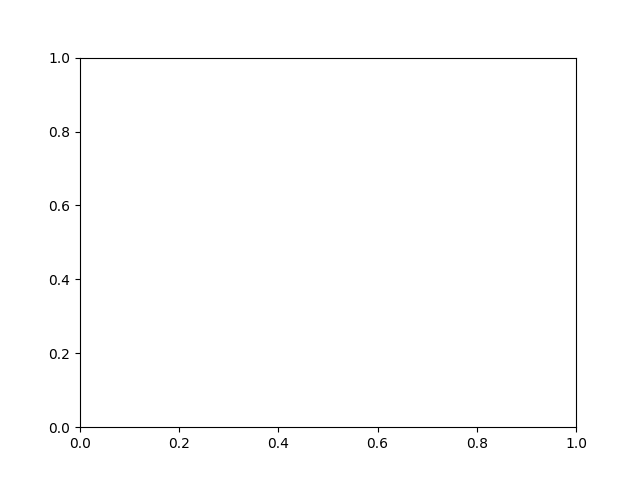

In [88]:
%matplotlib widget

ani, ax = visualize_graph_2sets(pos[0], vel[0], pos_gnn[0], vel_gnn[0],
                starting_frame = 0,
                file_id = 0)

### 6. Rollout

'\nm = "lazy"\n'